# CNN->DNN for multivariable time-series classification 


In [9]:
import tensorflow as tf
from keras.engine.topology import Layer,InputSpec

class CylindricalPad(Layer):

    def __init__(self, n=1, **kwargs):
        super(CylindricalPad, self).__init__(**kwargs)
        self.n = n
        assert n > 0, 'n must be positive'
        
    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        super(CylindricalPad, self).build(input_shape)  
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0],
                    input_shape[1],
                    input_shape[2],
                    input_shape[3] + 2*self.n)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0],
                    input_shape[1],
                    input_shape[2],
                    input_shape[3] + 2*self.n)
    
    def call(self,testElement, mask=None):
        firstColumns=testElement[:,:,:,0:self.n]
        lastColumns=testElement[:,:,:,testElement.shape[3]-self.n:testElement.shape[3]]
        result=tf.concat([testElement,firstColumns], axis=3)
        result=tf.concat([lastColumns,result], axis=3)
        return result

    
    
    def callasd(self, elementA, mask=None):
        
        print("###################################")
        shape=elementA.shape
        if shape[0].value == None :
            shape_aux=(shape[0],
                        shape[1],
                        shape[2],
                        shape[3] + 2*self.n)
            x = tf.placeholder(tf.float32, shape=shape_aux)
            y = tf.zeros_like(x)
            y = tf.random_uniform(shape_aux, minval=0, maxval=1, dtype=tf.float32)
            return y

        
        #return
        print(elementA.shape[0])
        x_unpacked = tf.unstack(elementA)
        batchResultFlat=[]
        for batchElement in x_unpacked:
            resultFlat=[]
            batchElementUnpack = tf.unstack(batchElement)
            for cnnFilterImage in batchElementUnpack:
                
                ind = tf.constant(list(range(self.n)))
                firstColumns = tf.transpose(tf.nn.embedding_lookup(tf.transpose(cnnFilterImage), ind))
                
                result = tf.concat([cnnFilterImage,firstColumns], axis=1)
                
                ind = tf.constant(list(range(cnnFilterImage.shape[1]-self.n,cnnFilterImage.shape[1])))
                lastColumns = tf.transpose(tf.nn.embedding_lookup(tf.transpose(cnnFilterImage), ind))
                
                result = tf.concat([lastColumns,result], axis=1)
                
                #firstColumns=cnnFilterImage[:,list(range(self.n))]
                #newElement=tf.pad(cnnFilterImage, paddings, "REFLECT") 
                resultFlat.append(result)
                
                #print(cnnFilterImage)
            batchResultFlat.append(tf.stack(resultFlat))
        ret = tf.stack(batchResultFlat)
        
        return ret

    def get_config(self):
        config = {'cropping': self.cropping}
        base_config = super(Cropping2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

print("CylindricalPad")

CylindricalPad


In [10]:
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
np.random.seed(1671)  # for reproducibility

sess = tf.Session()
K.set_session(sess)

#define the convnet 
class LeNet:
	@staticmethod
	def build(input_shape, classes):
		model = Sequential()
		#model.add(InputLayer())
		# CONV => RELU => POOL
		# kernel size (width, height) default (2,5)
		model.add(Conv2D(20, kernel_size=(2,5), padding="same",
			input_shape=input_shape))
                         #,batch_input_shape=(64,1, 5, 7)))
		model.add(Activation("relu"))
		# pool size - down scale int factor (vertical, horizontal)
		model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 1)))
		# CONV => RELU => POOL
		model.add(CylindricalPad(n=2))
		model.add(Conv2D(50, kernel_size=(3,5), padding="valid"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 1))) #1,2
		model.summary()
		model.add(Dropout(0.40))
		# Flatten => RELU layers
		model.add(Flatten())
		model.add(Dense(400))
		model.add(Activation("relu"))
		model.add(Dropout(0.5))
		model.add(Dense(150))
		model.add(Activation("relu"))
		model.add(Dropout(0.8))
		# a softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))
		#model.add(Dropout(0.3)) # not logical to do droput on last layer with softmax 
		return model

#------------- load Data ----------------

# special cross validation file 1 NNNormalizeData-out-set-0.csv
#df = pd.read_csv('../NNNormalizeData-out-set-1.csv',header=None)
#df = pd.read_csv('../NNNormalizeData-out.csv',header=None)
df = pd.read_csv('../NNNormalizeData-out.csv',header=None)  # 3 classes : up neutral down

np.random.seed(42) # always shuffle the same way 
df = df.reindex(np.random.permutation(df.index)) # shuffle examples 
df.reset_index(inplace=True, drop=True)

print(df)

inputs = []
target = []

y=0;    
for x in df.columns:
    if y != 35 :
        #print("added %d" %y)
        inputs.append(x)
    else :
        target.append(x)
    y+=1

print(inputs)



total_inputs,total_output = df.as_matrix(inputs).astype(np.float32),df.as_matrix([35]).astype(np.int32)

print(total_inputs)

total_inputs = np.reshape(total_inputs, (-1,5,7))
print('---------------------------')
print(total_inputs)

X_train=total_inputs
y_train=total_output

#X_train, y_train , X_test, y_test
#X_train, X_test, y_train , y_test = train_test_split(total_inputs, total_output, test_size=0.15, random_state=42)

#-------------- End Load Data -----------



NB_EPOCH = 200
# network and training
BATCH_SIZE = 64
VERBOSE = 1
OPTIMIZER = Adam()
VALIDATION_SPLIT=0.2

IMG_ROWS, IMG_COLS = 5, 7 # input image dimensions
NB_CLASSES = 5  # number of outputs = number of classes
INPUT_SHAPE = (1, IMG_ROWS, IMG_COLS)


K.set_image_dim_ordering("th")

# consider them as float and normalize
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
print("-------------- [0 , 1] ----------------------")
X_train += 1 
X_train /= 2
print(X_train)
#X_test += 1  

# we need a 60K x [1 x 28 x 28] shape as input to the CONVNET
X_train = X_train[:, np.newaxis, :, :]
#X_test = X_test[:, np.newaxis, :, :]


print(X_train.shape, 'train samples')
#print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, NB_CLASSES)
#y_test = np_utils.to_categorical(y_test, NB_CLASSES)

# initialize the optimizer and model
model = LeNet.build(input_shape=INPUT_SHAPE, classes=NB_CLASSES)
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])

model.summary()



             0         1         2         3         4         5         6   \
0     -0.723996  0.141094 -1.000000  0.625387  0.083214 -0.336045 -0.111275   
1     -0.242433 -0.087491 -0.292871  0.674107  0.240492  0.330299  1.000000   
2      0.514309 -0.801817 -0.881654 -0.560150  0.040320  0.078849  0.208871   
3     -0.036048 -0.573233  0.452922  0.414264  0.297684  0.041131  0.036484   
4      1.000000 -0.830390 -0.567637 -0.998636 -0.445811 -0.248037 -0.234408   
5      0.101541  0.598263  1.000000  1.000000  0.540749  1.000000 -0.887013   
6     -0.036048 -0.773244  1.000000 -0.625111 -1.000000  0.066276 -0.308288   
7     -0.999174 -0.144637  0.237034 -1.000000 -1.000000 -1.000000 -0.529927   
8      1.000000  0.055375 -0.037731  0.284342  0.512153 -0.864091 -0.074335   
9      0.032746  0.026802  0.923949  0.235621 -0.174149 -0.688076 -0.037395   
10    -0.380022  0.912566 -0.292871 -1.000000 -0.460109  0.430879  0.171931   
11    -0.036048  1.000000  1.000000  0.186901  0.054

/home/rjpg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 20, 5, 7)          220       
_________________________________________________________________
activation_16 (Activation)   (None, 20, 5, 7)          0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 20, 5, 6)          0         
_________________________________________________________________
cylindrical_pad_4 (Cylindric (None, 20, 5, 10)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 3, 6)          15050     
_________________________________________________________________
activation_17 (Activation)   (None, 50, 3, 6)          0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 3, 5)          0         
__________

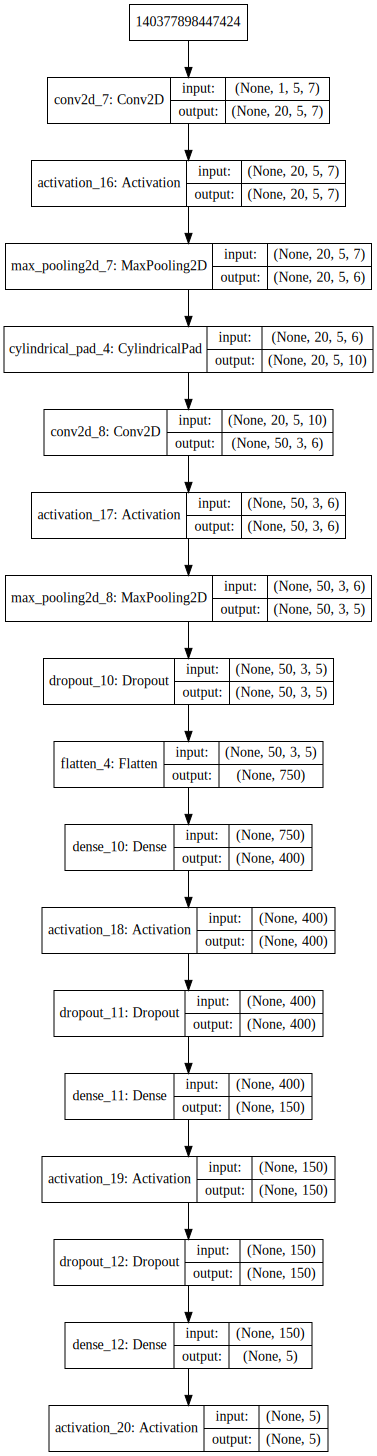

In [11]:
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
modelSVG=SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)


In [6]:
sess.run(tf.global_variables_initializer())


tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
esCallBack = EarlyStopping(monitor='val_acc', min_delta=0, patience=12, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)

history = model.fit(X_train, y_train, 
		batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
		verbose=1, # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
		validation_split=VALIDATION_SPLIT, callbacks=[tbCallBack,reduce_lr,esCallBack])


Train on 15564 samples, validate on 3892 samples
Epoch 1/200
15564/15564 [==============================] - 2s 108us/step - loss: 1.6013 - acc: 0.2404 - val_loss: 1.5942 - val_acc: 0.2474
Epoch 2/200
15564/15564 [==============================] - 2s 108us/step - loss: 1.5959 - acc: 0.2450 - val_loss: 1.5945 - val_acc: 0.2474
Epoch 3/200
15564/15564 [==============================] - 2s 106us/step - loss: 1.5954 - acc: 0.2442 - val_loss: 1.5926 - val_acc: 0.2474
Epoch 4/200
15564/15564 [==============================] - 2s 107us/step - loss: 1.5933 - acc: 0.2481 - val_loss: 1.5900 - val_acc: 0.2479
Epoch 5/200
15564/15564 [==============================] - 2s 106us/step - loss: 1.5885 - acc: 0.2503 - val_loss: 1.5835 - val_acc: 0.2575
Epoch 6/200
15564/15564 [==============================] - 2s 106us/step - loss: 1.5834 - acc: 0.2600 - val_loss: 1.5800 - val_acc: 0.2567
Epoch 7/200
15564/15564 [==============================] - 2s 110us/step - loss: 1.5734 - acc: 0.2645 - val_loss: 1.5

15564/15564 [==============================] - 2s 107us/step - loss: 0.6286 - acc: 0.7640 - val_loss: 0.8820 - val_acc: 0.6927
Epoch 60/200
15564/15564 [==============================] - 2s 105us/step - loss: 0.6099 - acc: 0.7738 - val_loss: 0.8840 - val_acc: 0.6860
Epoch 61/200
15564/15564 [==============================] - 2s 107us/step - loss: 0.6086 - acc: 0.7735 - val_loss: 0.8863 - val_acc: 0.6809
Epoch 62/200
15564/15564 [==============================] - 2s 106us/step - loss: 0.6004 - acc: 0.7738 - val_loss: 0.8672 - val_acc: 0.6883
Epoch 63/200
15564/15564 [==============================] - 2s 106us/step - loss: 0.5887 - acc: 0.7778 - val_loss: 0.8659 - val_acc: 0.7002
Epoch 64/200
15564/15564 [==============================] - 2s 106us/step - loss: 0.5844 - acc: 0.7835 - val_loss: 0.8742 - val_acc: 0.6914
Epoch 65/200
15564/15564 [==============================] - 2s 108us/step - loss: 0.5852 - acc: 0.7803 - val_loss: 0.8740 - val_acc: 0.6950
Epoch 66/200
15564/15564 [=======

KeyboardInterrupt: 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


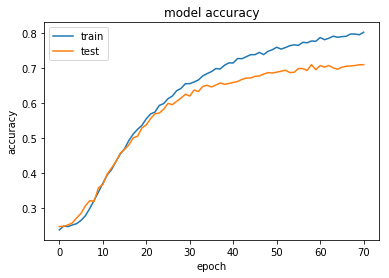

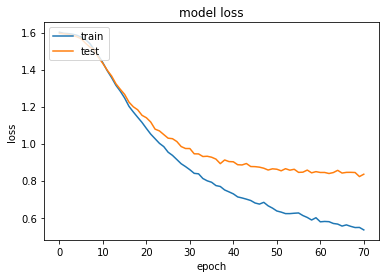

In [5]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
